In [67]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, TimeDistributed, Dense, Activation, SpatialDropout1D

from matplotlib import pyplot as plt

# Importing libraries
# https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import json

from wordcloud import WordCloud

SRC_COMMENTS_POL = '../data/guardian-all/sorted_comments-standardized-pol.csv'
SRC_COMMENTS_POL_TEXT = '../data/guardian-all/sorted_comments-standardized-pol-text.csv'

def plot_distribution(Y_valid, Y_train):
    neg_valid, pos_valid = Y_valid.sum(axis=0)
    neg_train, pos_train = Y_train.sum(axis=0)
    pos = [pos_train, pos_valid]
    neg = [neg_train, neg_valid]
    plt.bar(['Train', 'Val'], pos, 0.5, color='lightblue', label='Good')
    plt.bar(['Train', 'Val'], neg, 0.5, color='orange', bottom=pos, label='Bad')
    plt.legend()
    plt.text(-0.05, pos[0] + neg[0] / 2, neg[0], color='red', fontweight='bold')
    plt.text(-0.05, pos[0] / 2, pos[0], color='blue', fontweight='bold')
    plt.text(0.95, pos[1] + neg[1] / 2, neg[1], color='red', fontweight='bold')
    plt.text(0.95, pos[1] / 2, pos[1], color='blue', fontweight='bold')

def plot_history(history):
    plt.plot(history.history['acc'], 'b', label='Train Acc')
    plt.plot(history.history['loss'], 'r', label='Train Loss')
    plt.plot(history.history['val_acc'], 'b--', label='Val Acc')
    plt.plot(history.history['val_loss'], 'r--', label='Val Loss')
    plt.legend()

In [2]:
data = pd.read_csv(SRC_COMMENTS_POL, usecols=['comment_text', 'upvotes'])

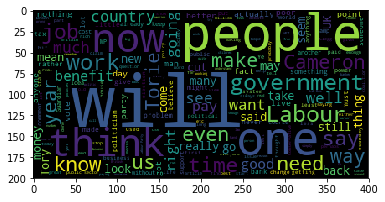

In [3]:
wordcloud = WordCloud().generate(' '.join(data['comment_text']))
plt.imshow(wordcloud)

In [4]:
# 1308 comments contain Cameron
data = data[data['comment_text'].str.contains('Cameron')]

In [5]:
data['sentiment']=['pos' if x > 2 else 'neg' for x in data['upvotes']]  # 2 -> 7513 vs. 5867
data['comment_text'] = data['comment_text'].apply(lambda x: x.lower())
data['comment_text'] = data['comment_text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
data['comment_text']= [x.encode('ascii', 'ignore').decode() for x in data['comment_text']]

### Experiments

In [57]:
words = 600

In [58]:
tokenizer = Tokenizer(num_words=words, split=' ')
tokenizer.fit_on_texts(data['comment_text'].values)
# print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(data['comment_text'].values)
X = pad_sequences(X)

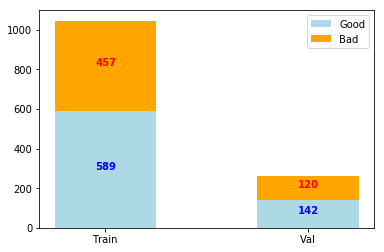

In [59]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size = 0.20, random_state = 36)
plot_distribution(Y_valid, Y_train)

In [63]:
embed_dim = 128
lstm_out = 64
batch_size = 16

model = Sequential()
model.add(Embedding(words, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(lstm_out, return_sequences=True, recurrent_dropout=0.3, dropout=0.3))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 626, 128)          76800     
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 626, 128)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 626, 64)           49408     
_________________________________________________________________
lstm_23 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130       
Total params: 159,362
Trainable params: 159,362
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Here we train the Network.
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size = 32, epochs = 20,  verbose = 2)

Train on 1046 samples, validate on 262 samples
Epoch 1/20
 - 64s - loss: 0.6866 - acc: 0.5583 - val_loss: 0.6910 - val_acc: 0.5420
Epoch 2/20
 - 56s - loss: 0.6797 - acc: 0.5698 - val_loss: 0.6882 - val_acc: 0.5763
Epoch 3/20
 - 56s - loss: 0.6343 - acc: 0.6463 - val_loss: 0.7102 - val_acc: 0.5725
Epoch 4/20
 - 56s - loss: 0.5553 - acc: 0.7180 - val_loss: 0.7651 - val_acc: 0.5344
Epoch 5/20
 - 56s - loss: 0.4780 - acc: 0.7715 - val_loss: 0.8627 - val_acc: 0.5344
Epoch 6/20
 - 57s - loss: 0.4510 - acc: 0.7859 - val_loss: 0.8604 - val_acc: 0.5458
Epoch 7/20
 - 57s - loss: 0.4160 - acc: 0.8174 - val_loss: 1.0235 - val_acc: 0.5496
Epoch 8/20
 - 57s - loss: 0.3619 - acc: 0.8413 - val_loss: 1.0053 - val_acc: 0.5344
Epoch 9/20
 - 57s - loss: 0.2951 - acc: 0.8824 - val_loss: 1.2330 - val_acc: 0.5420
Epoch 10/20
 - 57s - loss: 0.2802 - acc: 0.8910 - val_loss: 1.2080 - val_acc: 0.5496
Epoch 11/20
 - 56s - loss: 0.2511 - acc: 0.8901 - val_loss: 1.2922 - val_acc: 0.5611
Epoch 12/20
 - 58s - loss: 

Only 600 words, a bit more embedding dim (128) and lstm out (64)

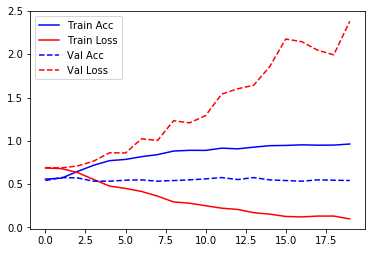

In [68]:
plot_history(history)

Less embedding units, less dropout

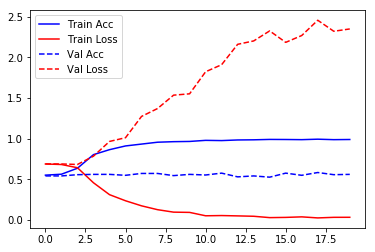

In [56]:
plot_history(history)

Less hidden units (32 instead of 512)

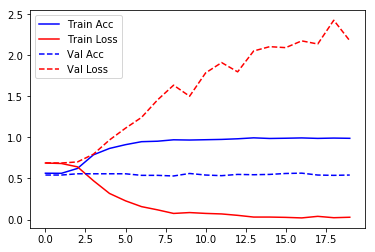

In [52]:
plot_history(history)

256 LSTM units

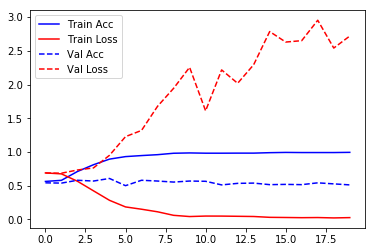

In [48]:
plot_history(history)

lstm_out = 512 -> Takes too long

2500 words and more dropout (99% on train with low dropout)

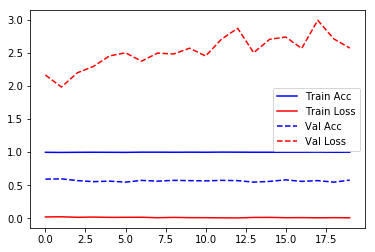

In [41]:
plot_history(history)

1000 words

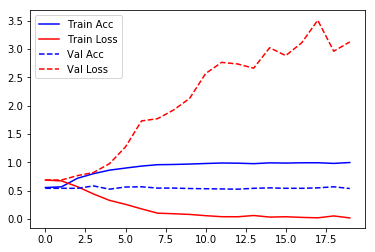

In [30]:
plot_history(history)

Try #1

In [ ]:
embed_dim = 64
lstm_out = 256
batch_size = 32

model = Sequential()
model.add(Embedding(words, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, return_sequences=True, recurrent_dropout=0.1, dropout=0.1))
model.add(LSTM(lstm_out, recurrent_dropout=0.1, dropout=0.5))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adadelta', metrics = ['accuracy'])

In [19]:
# Here we train the Network.
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size = 32, epochs = 20,  verbose = 2)

Train on 1046 samples, validate on 262 samples
Epoch 1/20
 - 287s - loss: 0.6884 - acc: 0.5574 - val_loss: 0.6902 - val_acc: 0.5420
Epoch 2/20
 - 225s - loss: 0.6860 - acc: 0.5631 - val_loss: 0.6918 - val_acc: 0.5420
Epoch 3/20
 - 198s - loss: 0.6853 - acc: 0.5631 - val_loss: 0.6905 - val_acc: 0.5420
Epoch 4/20
 - 199s - loss: 0.6841 - acc: 0.5631 - val_loss: 0.6914 - val_acc: 0.5420
Epoch 5/20
 - 213s - loss: 0.6817 - acc: 0.5631 - val_loss: 0.6921 - val_acc: 0.5420
Epoch 6/20
 - 208s - loss: 0.6792 - acc: 0.5621 - val_loss: 0.6914 - val_acc: 0.5420
Epoch 7/20
 - 200s - loss: 0.6737 - acc: 0.5755 - val_loss: 0.6917 - val_acc: 0.5305
Epoch 8/20
 - 203s - loss: 0.6681 - acc: 0.6061 - val_loss: 0.6951 - val_acc: 0.5191
Epoch 9/20
 - 220s - loss: 0.6548 - acc: 0.6243 - val_loss: 0.6978 - val_acc: 0.5305
Epoch 10/20
 - 235s - loss: 0.6421 - acc: 0.6511 - val_loss: 0.7110 - val_acc: 0.4962
Epoch 11/20
 - 238s - loss: 0.6387 - acc: 0.6386 - val_loss: 0.7028 - val_acc: 0.5458
Epoch 12/20
 - 2

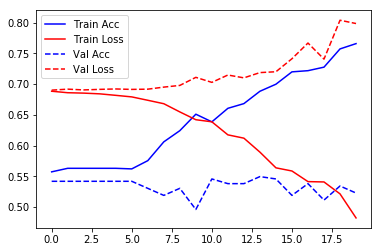

In [20]:
plot_history(history)

In [142]:
# Measuring score and accuracy on validation set

score,acc = model.evaluate(X_valid, Y_valid, verbose = 2, batch_size = batch_size)
print("Logloss score: %.2f" % (score))
print("Validation set Accuracy: %.2f" % (acc))

Logloss score: 3.94
Validation set Accuracy: 0.56


In [11]:
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))

NameError: name 'vocabulary' is not defined